In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import scipy.stats
import scipy.special

import pickle as pkl
from collections import Counter

from haplm.hap_util import mat_by_marker, num_to_str, str_to_num
from sim_data import parse_sim_data

In [2]:
n_datasets = 100
n_pools = 20
n_markers = 8
pool_size = 50

In [3]:
def get_pmean(idata):
    return idata.posterior.p.values.mean(axis=(0,1))

def get_pstd(idata):
    return idata.posterior.p.values.std(axis=(0,1))

def get_pess(idata):
    return az.ess(idata, var_names=['p'])['p'].values

def dataset_to_dict(dataset):
    d = dataset.to_dict()
    output = d['attrs'].copy()
    for name, info in d['data_vars'].items():
        output[name] = info['data']
    return output

def get_tot_time(sample_stats):
    if 'preprocess_time' not in sample_stats:
        return sample_stats['time_incl_tune'].values.sum()
    
    longest = sample_stats.time_incl_tune.values.max()
    return (sample_stats['preprocess_time']
            + sample_stats['mcmc_walltime'] - longest
            + sample_stats.time_incl_tune.values.sum()) 

def est_time(sample_stats, ess, trg_ess):
    if 'preprocess_time' not in sample_stats:
        incl = sample_stats['time_incl_tune'].values
        excl = sample_stats['time_excl_tune'].values
        return ((incl-excl) + excl*trg_ess/ess).sum()
    
    longest = sample_stats.time_incl_tune.values.max()
    return (sample_stats['preprocess_time']
            + sample_stats['mcmc_walltime'] - longest
            + sample_stats.time_incl_tune.values.sum()*trg_ess/ess) 

def get_walltime(smpl_stat_dict):
    if 'preprocess_time' not in smpl_stat_dict:
        return np.array(smpl_stat_dict['time_incl_tune']).sum()
    
    return smpl_stat_dict['preprocess_time'] + smpl_stat_dict['mcmc_walltime']

def get_tvd(ptrue, pest):
    return 0.5*(ptrue.sub(pest, fill_value=0).abs().sum())

def get_ess(ptrue, haps, ess):
    return [val for hnum, val in zip(haps, ess) if num_to_str(hnum, n_markers) in ptrue.index]

def make_series(arr, hnums, n_markers):
    return pd.Series(arr, index=[num_to_str(hnum, n_markers) for hnum in hnums])

In [4]:
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=14)

# colors for plotting
colors = [
    '#1b9e77',
    '#d95f02',
    '#7570b3',
    '#e7298a',
    '#66a61e',
    '#e6ab02'
]

In [9]:
ptrue_list = []
for i in range(n_datasets):
    ds_idx = i + 1
    fn_prefix = f'../../data/encode/psize{pool_size}_m{n_markers}_id{ds_idx}'
    with open(f'{fn_prefix}.prob') as fp:
        ptrue = pd.Series({line.split()[0]: float(line.split()[1]) for line in fp})
    ptrue_list.append(ptrue)

haps_list = []
pl_coverage = []
ehaps_list = []
amats = []
with open('../../data/encode/PL.txt') as fp:
    for i, line in enumerate(fp):
        haps = [int(x) for x in line.split()]
        haps_list.append(haps)
        ehaps_list.append(set(ptrue_list[i].index) - {num_to_str(hap, n_markers) for hap in haps})
        pl_coverage.append(sum(ptrue_list[i].get(num_to_str(hap, n_markers), 0) for hap in haps))
        amats.append(np.array([[(hnum >> m) & 1 for hnum in haps] for m in range(n_markers)]))

In [6]:
# number of datasets where PL finds all true haplotypes
sum(len(ehaps) == 0 for ehaps in ehaps_list)

34

## Inference results

In [7]:
# init stats
stats = [{} for _ in range(n_datasets)]

In [14]:
# get stats from MCMC results (Bayesian)
for method in ['mn_approx', 'cgibbs', 'hippo']:
    print(method, end=' ')
    for i in range(n_datasets):
        print(i+1, end=' ')
        stats_dict = stats[i]
        fn_prefix = f'../../data/encode/psize{pool_size}_m{n_markers}_id{i+1}'    
        H = len(haps_list[i])

        idata = az.from_netcdf(f'{fn_prefix}_{method}.netcdf')
        
        if 'hippo' in method:
            haps = list(range(2**n_markers))
        else:
            haps = haps_list[i]
        
        pmean = make_series(get_pmean(idata), haps, n_markers)
        pstd = make_series(get_pstd(idata), haps, n_markers)
        
        ptrue = np.array([ptrue_list[i].get(num_to_str(hnum, n_markers), 0) for hnum in haps])
        quants = (np.vstack(idata.posterior.p) < ptrue).mean(axis=0)

        stats_dict[method] = {'pmean': pmean, # posterior mean
                              'pstd': pstd, # posterior SD
                              'qs': quants,
                              'pess': get_pess(idata), # ESS of p
                              'sample_stats': dataset_to_dict(idata.sample_stats) # timings
                             }
    print()

mn_approx 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
cgibbs 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
hippo 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 


In [10]:
sum(get_walltime(sdict['hippo']['sample_stats']) for sdict in stats)

38669.81395983696

In [10]:
# get stats from AEML
for i in range(n_datasets):
    fn = f'../../data/encode/psize{pool_size}_m{n_markers}_id{i+1}_aeml.pkl'            
    with open(fn, 'rb') as fp:
        stats[i]['AEML'] = pkl.load(fp)
        stats[i]['AEML']['pseries'] = make_series(stats[i]['AEML']['pest'], haps_list[i], n_markers)

In [13]:
sum(sdict['AEML']['time'] for sdict in stats)/100

10.922844231128693

## ESS

In [45]:
print('LC-Sampling')
lowess = []
for i in range(n_datasets):
    lowess.append((stats[i]['cgibbs']['pess'].min(), i))
    # for h, val in enumerate(stats[i]['cgibbs']['pess']):
    #     lowess.append((val, i, h))
for tpl in sorted(lowess):
    if tpl[0] > 200:
        break
    print(f'Set {tpl[1]:2} has ESS = {round(tpl[0]):3}, with {len(ehaps_list[tpl[1]])} missing haplotypes')

LC-Sampling
Set 38 has ESS =  30, with 1 missing haplotypes
Set 88 has ESS =  55, with 0 missing haplotypes
Set  8 has ESS = 125, with 5 missing haplotypes
Set 27 has ESS = 133, with 0 missing haplotypes


[2512.66259881 2343.47127668 2463.36708309 2544.5072266  2424.76976646
 2393.03631619   55.1412096  2481.77840565 2567.60991439 2349.26920371
 2378.58603438 2551.51692326 2418.36982058 2716.22610907 2622.3935423
 2202.51115736 2553.70852615 2556.04766998 2640.13624186 2595.01448138
 2575.14356447 2329.94485035 2123.62167247 2533.96897923]


/home/ysfoo/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


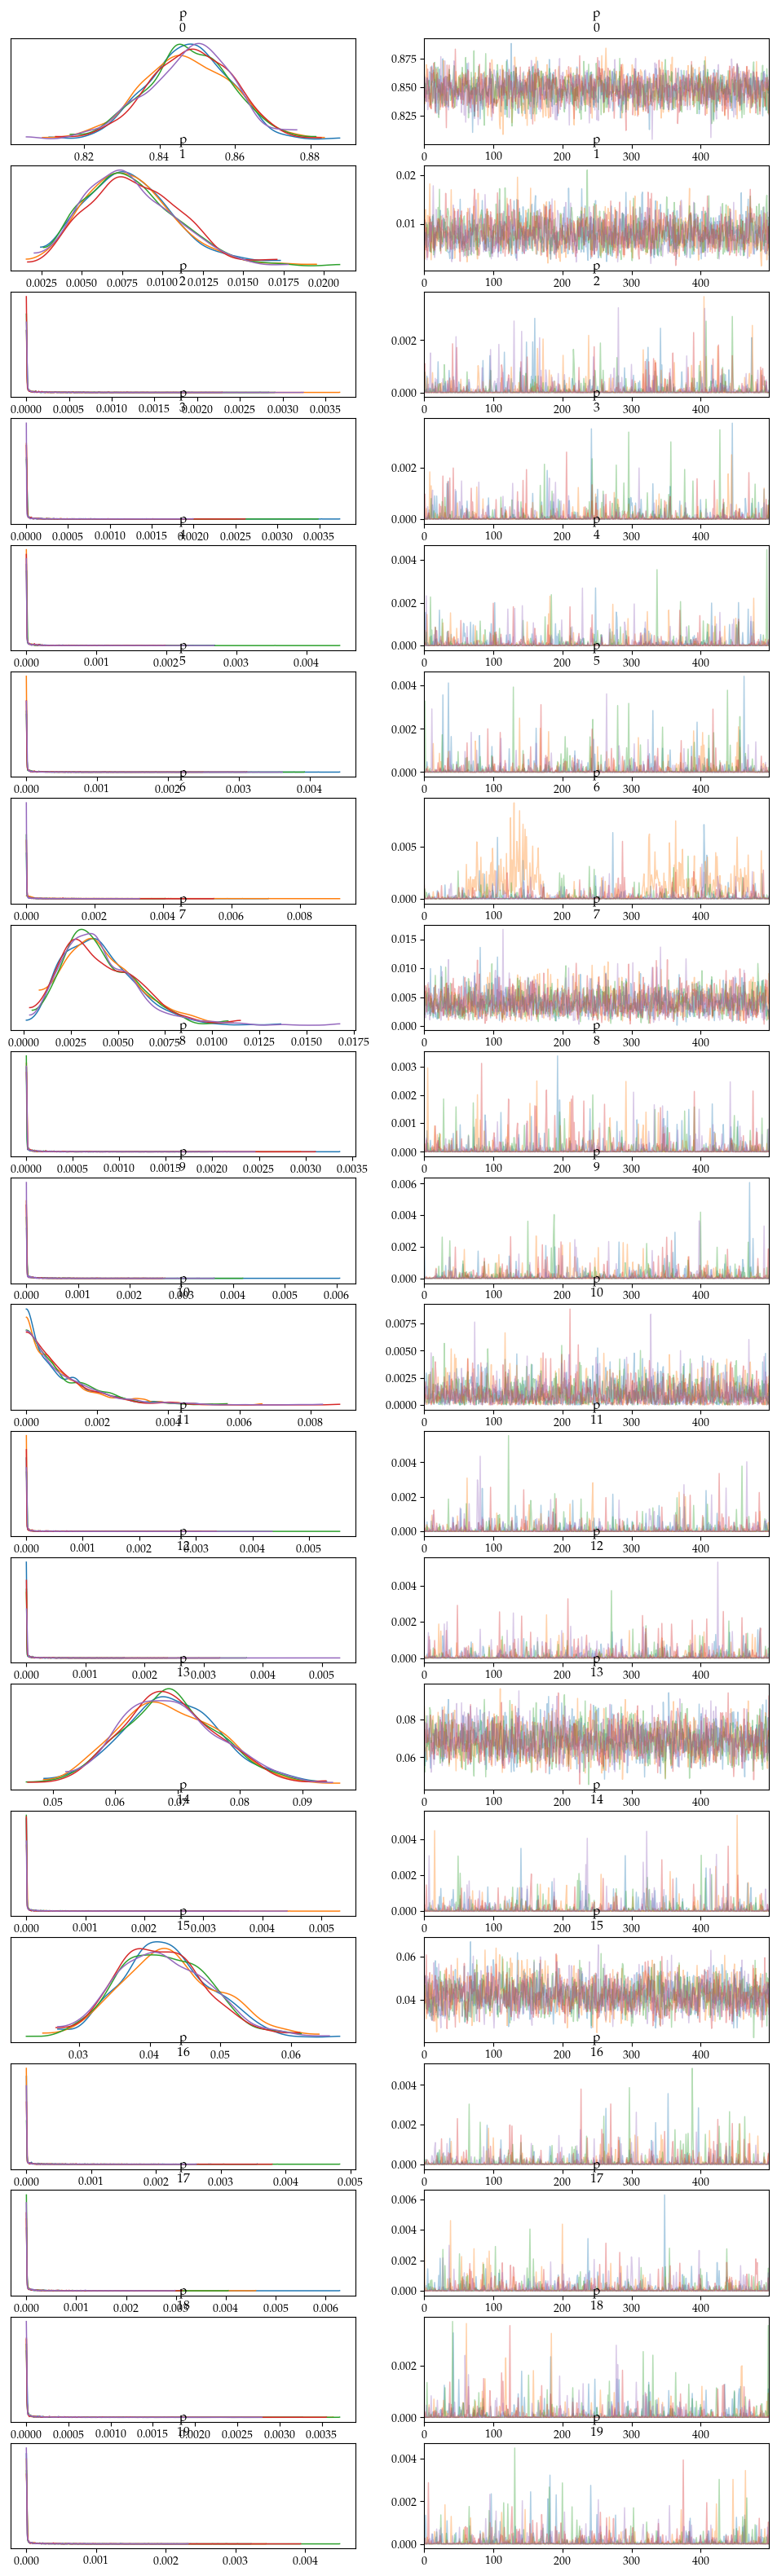

In [30]:
i = 88
idata = az.from_netcdf(f'../../data/encode/psize{pool_size}_m{n_markers}_id{i+1}_cgibbs.netcdf');
print(stats[i]['cgibbs']['pess'])
az.plot_trace(idata, var_names=['p'], compact=False);

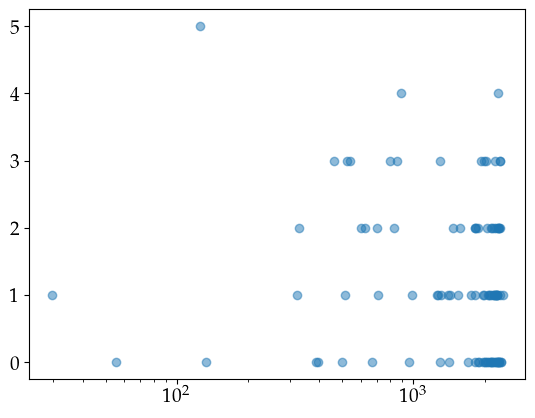

In [11]:
plt.scatter([tpl[0] for tpl in lowess], [len(ehaps) for ehaps in ehaps_list], alpha=0.5);
plt.xscale('log');

In [46]:
print('MCMC-Approx')
lowess = []
for i in range(n_datasets):
    lowess.append((stats[i]['mn_approx']['pess'].min(), i))
for tpl in sorted(lowess):
    if tpl[0] > 200:
        break
    print(f'Set {tpl[1]:2} has ESS = {round(tpl[0]):3}, with {len(ehaps_list[tpl[1]])} missing haplotypes')

MCMC-Approx
Set 90 has ESS =   8, with 1 missing haplotypes
Set 88 has ESS =   8, with 0 missing haplotypes
Set 62 has ESS =  10, with 3 missing haplotypes
Set 31 has ESS =  10, with 4 missing haplotypes
Set 27 has ESS =  14, with 0 missing haplotypes
Set 37 has ESS =  55, with 0 missing haplotypes
Set 43 has ESS =  98, with 1 missing haplotypes
Set 33 has ESS = 116, with 2 missing haplotypes
Set  2 has ESS = 123, with 3 missing haplotypes
Set 42 has ESS = 124, with 2 missing haplotypes
Set 61 has ESS = 127, with 2 missing haplotypes
Set 73 has ESS = 137, with 1 missing haplotypes
Set 64 has ESS = 138, with 0 missing haplotypes
Set 29 has ESS = 150, with 1 missing haplotypes
Set 26 has ESS = 159, with 2 missing haplotypes
Set 81 has ESS = 170, with 0 missing haplotypes
Set 32 has ESS = 177, with 1 missing haplotypes
Set 71 has ESS = 180, with 1 missing haplotypes
Set 16 has ESS = 180, with 2 missing haplotypes
Set 70 has ESS = 183, with 1 missing haplotypes
Set 41 has ESS = 191, with 0

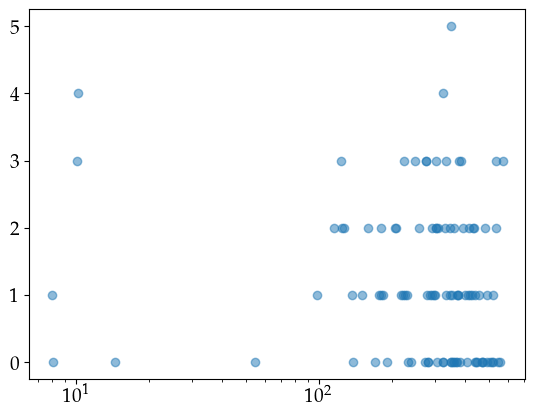

In [13]:
plt.scatter([tpl[0] for tpl in lowess], [len(ehaps) for ehaps in ehaps_list], alpha=0.5);
plt.xscale('log');

In [47]:
print('HIPPO')
lowess = []
for i in range(n_datasets):
    lowess.append((stats[i]['hippo']['pess'].min(), i))
for tpl in sorted(lowess):
    if tpl[0] > 200:
        break
    print(f'Set {tpl[1]:2} has ESS = {round(tpl[0]):3}')

HIPPO
Set 26 has ESS =   6
Set  8 has ESS =   8
Set 25 has ESS =   8
Set 79 has ESS =   8
Set  2 has ESS =   8
Set 32 has ESS =   8
Set 31 has ESS =   9
Set  4 has ESS =  12
Set 46 has ESS =  14
Set 10 has ESS =  14
Set 27 has ESS =  14
Set 33 has ESS =  15
Set 34 has ESS =  18
Set 18 has ESS =  20
Set 16 has ESS =  20
Set 71 has ESS =  22
Set 14 has ESS =  22
Set 44 has ESS =  23
Set 13 has ESS =  23
Set  6 has ESS =  25
Set  7 has ESS =  30
Set 35 has ESS =  31
Set  9 has ESS =  34
Set  5 has ESS =  35
Set 41 has ESS =  42
Set 40 has ESS =  43
Set 58 has ESS =  51
Set  0 has ESS =  52
Set 38 has ESS =  53
Set 53 has ESS =  56
Set 80 has ESS =  69
Set 19 has ESS =  76
Set 81 has ESS =  81
Set 91 has ESS =  83
Set 17 has ESS =  87
Set 50 has ESS =  88
Set 89 has ESS =  91
Set 39 has ESS =  94
Set 87 has ESS =  96
Set 11 has ESS = 114
Set 65 has ESS = 126
Set 97 has ESS = 132
Set 12 has ESS = 133
Set 63 has ESS = 152
Set 62 has ESS = 175
Set 70 has ESS = 183
Set 95 has ESS = 183
Set 52 

## TVDs

In [15]:
cgibbs_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['cgibbs']['pmean']) for i in range(n_datasets)])
mn_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['mn_approx']['pmean']) for i in range(n_datasets)])
hippo_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['hippo']['pmean']) for i in range(n_datasets)])
aeml_tvd = np.array([get_tvd(ptrue_list[i], stats[i]['AEML']['pseries']) for i in range(n_datasets)])

In [16]:
cgibbs_ess_all = np.concatenate([stats[i]['cgibbs']['pess'] for i in range(n_datasets)])
mn_ess_all = np.concatenate([stats[i]['mn_approx']['pess'] for i in range(n_datasets)])
hippo_ess_all = np.concatenate([stats[i]['hippo']['pess'] for i in range(n_datasets)])                   

In [17]:
cgibbs_mean_all = np.concatenate([stats[i]['cgibbs']['pmean'] for i in range(n_datasets)])
mn_mean_all = np.concatenate([stats[i]['mn_approx']['pmean'] for i in range(n_datasets)])
hippo_mean_all = np.concatenate([stats[i]['hippo']['pmean'] for i in range(n_datasets)])

In [18]:
thres = 1e-3
(cgibbs_mean_all > thres).sum(), (mn_mean_all > thres).sum(), (hippo_mean_all > thres).sum()

(1138, 1176, 1103)

In [19]:
ess_plot = [mn_ess_all[mn_mean_all > thres],
            cgibbs_ess_all[cgibbs_mean_all > thres],
            [],
            hippo_ess_all[hippo_mean_all > thres]][::-1]

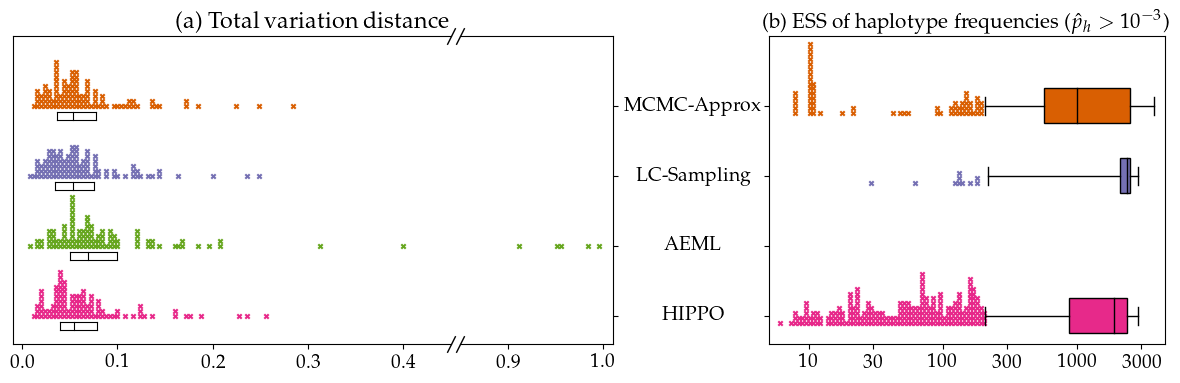

In [53]:
markers = 'xxxx'[::-1]
tmp_colors = [colors[i] for i in [1, 2, 4, 3]][::-1]

tvd_plot = [mn_tvd,
            cgibbs_tvd,
            aeml_tvd,
            hippo_tvd][::-1]

nplots = len(tvd_plot)

fig = plt.figure(figsize=(12, 4))
gs1 = fig.add_gridspec(1, 2, wspace=0.03, right=0.52, width_ratios=[46,16])
ax1, ax2 = gs1.subplots()
# hide the spines between ax1 and ax2
ax1.spines.right.set_visible(False)
ax1.set_yticks([])
ax2.spines.left.set_visible(False)
ax2.set_yticks(np.arange(nplots), ['']*nplots)
ax2.yaxis.tick_right()

ystep = 0.07
for i, row in enumerate(tvd_plot):
    for vals, ax in zip((row[row < 0.45], row[row > 0.85]), (ax1, ax2)):
        scale = 250
        c = Counter(np.round(scale*vals).astype(int))
        for x, h in c.items():
            y1 = i #0.5*ystep*(h-1)+i
            ax.scatter([x/scale]*h, np.arange(y1, y1+ystep*(h-0.5), ystep),
                       s=10, marker=markers[i], color=tmp_colors[i])
    qs = np.quantile(row, [0.25, 0.5, 0.75])
    for q in qs:
        ax1.plot([q,q], [i-0.2,i-0.08], '-', color='k', linewidth=0.8)
    ax1.plot(qs, [i-0.08]*3, '-', color='k', linewidth=0.8)
    ax1.plot(qs, [i-0.2]*3, '-', color='k', linewidth=0.8)

ax1.set_xlim((-0.01, 0.45))
ax2.set_xlim((0.85, 1.01))
ax1.set_ylim((-0.4, nplots))
ax2.set_ylim((-0.4, nplots))

ax_left = fig.add_subplot(gs1[:])
ax_left.axis('off')
ax_left.set_title('(a) Total variation distance')

d = 2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

# right plot
gs2 = fig.add_gridspec(1, 1, wspace=0, left=0.65)
ax = gs2.subplots()

thres = 200
for i, row in enumerate(ess_plot):
    row = np.array(row)
    ax.boxplot(np.log(row[row > thres]), vert=False,
               positions=[i], widths=[0.5],
               whis=(0,100),
               patch_artist=True, boxprops=dict(facecolor=tmp_colors[i]),
               medianprops=dict(color='k'))
    vals = np.log(row[row < thres])
    scale = 16
    c = Counter(np.round(scale*vals).astype(int))
    for x, h in c.items():
        y1 = i-0.1 #0.5*ystep*(h-1)+i
        ax.scatter([x/scale]*h, np.arange(y1, y1+ystep*(h-0.5), ystep),
                   s=10, marker=markers[i], color=tmp_colors[i])

# ax.set_xscale('log')
ax.set_xlim(np.log([5, 4500]))
xticks = [10, 30, 100, 300, 1000, 3000]
ax.set_xticks(np.log(xticks), xticks)
ax.set_title(r'(b) ESS of haplotype frequencies ($\hat{p}_h>10^{-3}$)', fontsize=15)
ax.set_ylim((-0.4, nplots))
ax.set_yticks(ticks=np.arange(nplots),
              labels=['MCMC-Approx',
                      'LC-Sampling',
                      'AEML',
                      'HIPPO'][::-1],
              fontsize=14)
ax.tick_params(axis="y", pad=51)
plt.setp(ax.get_yticklabels(), ha="center", va="center")
plt.subplots_adjust(left=0.02, right=0.98);
plt.savefig('kgenomes_tvd_ess.png', dpi=200, facecolor='white');

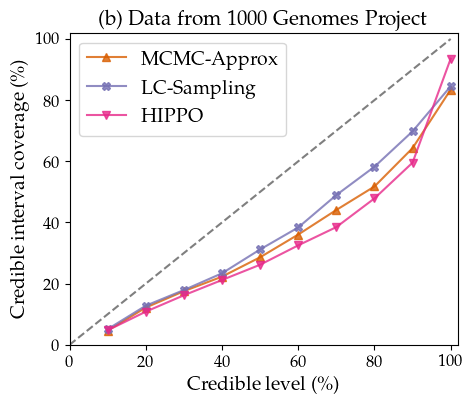

In [40]:
name_dict = {'mn_approx': 'MCMC-Approx',
             'cgibbs': 'LC-Sampling',
             'hippo': 'HIPPO'}
markers = '^Xv'
tmp_colors = [colors[i] for i in [1, 2, 3]]

plt.figure(figsize=(6*0.8, 5*0.8))
for j, method in enumerate(['mn_approx', 'cgibbs', 'hippo']):
    quants = []
    for i in range(n_datasets):
        if 'hippo' in method:
            haps = list(range(2**n_markers))
        else:
            haps = haps_list[i]
        tmp = [v for hnum, v in zip(haps, stats[i][method]['qs'])
               if num_to_str(hnum, n_markers) in ptrue_list[i].index]
               #and ptrue_list[i][num_to_str(hnum, n_markers)] > 0.01]
        #tmp = [v for v in stats[i][method]['qs']]
        tmp += [1]*(len(ptrue_list[i]) - len(tmp))
        quants += tmp
    
    quants = np.array(quants)
    alphas = np.arange(1, 11) / 10
    coverage = []
    for alpha in alphas:
        coverage.append((abs(quants - 0.5) < alpha/2).mean())
    plt.plot(alphas*100, 100*np.array(coverage), f'{markers[j]}-', alpha=0.8, color=tmp_colors[j],
             label=name_dict[method], markersize=6)
plt.plot([0,100], [0,100], '--', alpha=0.5, color='k')

plt.xlim((0,102))
plt.ylim((0,102))

plt.xlabel('Credible level (\%)', fontsize=14)
plt.ylabel('Credible interval coverage (\%)', fontsize=14)
plt.legend(fontsize=14);
plt.title('(b) Data from 1000 Genomes Project', fontsize=15);
plt.tick_params(axis='both', which='both', labelsize=12)

plt.subplots_adjust(top=0.92, left=0.15, right=0.96, bottom=0.14);
plt.savefig('kgenomes_coverage.png', dpi=200, facecolor='white');

## Univariate posteriors for investigating multimodality

In [38]:
plt.ioff()
for i in range(100):
    psize = 50
    idata = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_cgibbs.netcdf')
    postp = np.vstack(idata.posterior.p)
    
    idata_mn = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_mn_approx.netcdf')
    postp_mn = np.vstack(idata_mn.posterior.p)
    
    pmean = make_series(get_pmean(idata), haps_list[i], n_markers)
    ptrue = ptrue_list[i]
    idxs = []
    hstrs = []
    for idx, hnum in enumerate(haps_list[i]):
        hstr = num_to_str(hnum, 8)
        if True:#hstr in ptrue.index:
            idxs.append(idx)
            hstrs.append(hstr)

    nrow = (len(pmean) - 1) // 6 + 1
    fig, axes = plt.subplots(nrows=nrow, ncols=6, figsize=(12, 2*nrow))
    for j in range(6*nrow):
        ax = axes[j//6][j%6]   
        if j >= len(hstrs):
            fig.delaxes(ax)
            continue        
        # az.plot_kde(pred_samples_t10[:,j], ax=ax)
        grid, dens = az.stats.density_utils.kde(postp[:,idxs[j]], bw='scott')
        ax.plot(grid, dens, alpha=0.5)
        
        grid, dens = az.stats.density_utils.kde(postp_mn[:,idxs[j]], bw='scott')
        ax.plot(grid, dens, alpha=0.5)
        
        ax.plot([ptrue.get(hstrs[j], 0)]*2, ax.get_ylim(), '--', color='k', linewidth=1)
        # diffs = np.diff(dens)
        # for k in range(1, len(diffs)):
        #     if diffs[k] < 0 and diffs[k-1] > 0:
        #         ax.scatter(grid[k], dens[k], s=10, color='k', alpha=0.5)
        # ax.plot([ptrue.get(hstrs[j], 0)]*2, [0,ax.get_ylim()[1]*0.9], '--', color='k', alpha=0.5)
        ax.set_title(f'Hap. {hstrs[j]}', fontsize=12)
        if len(hstrs) - j <= 6:
            ax.set_xlabel('Haplotype frequency', fontsize=10)
        ax.set_xticks([])
        if j % 6 == 0:
            ax.set_ylabel(f'Posterior density', fontsize=10)
        ax.set_yticks([])
    plt.savefig(f'post_kdes/i{i}.png', dpi=200, facecolor='white');
    plt.close('all')
    # fig.subplots_adjust(hspace=0.1)
plt.ion()

In [424]:
print([i for i, e in enumerate(ehaps_list) if not e])

[3, 4, 5, 7, 12, 13, 25, 27, 36, 37, 39, 40, 41, 44, 45, 46, 50, 51, 53, 57, 59, 64, 66, 69, 72, 74, 80, 81, 83, 85, 87, 88, 91, 96]


In [15]:
i = 2
psize = 50
method = 'cgibbs'
idata = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_{method}.netcdf')
postp = np.vstack(idata.posterior.p)
pmean = stats[i][method]['pmean']
ptrue = ptrue_list[i]
idxs = []
hstrs = []
for idx, hnum in enumerate(haps_list[i]):
    hstr = num_to_str(hnum, 8)
    if True:
    # if hstr in ptrue.index:
    # if stats[i][method]['pess'][idx] < 50:
        idxs.append(idx)
        hstrs.append(hstr)
print(stats[i][method]['pess'])
len(pmean), len(hstrs), get_tvd(ptrue, pmean), stats[i][method]['pess'].min(), ehaps_list[i]

[ 521.23358006 1870.07447267 2383.54985293 2500.64360728 2516.3290213
  506.3097779  2436.51257468  475.78984953 2518.05407684  461.49044734
 2383.75829356 1945.34638781 2449.08499886]


(13,
 13,
 0.11543454691190863,
 461.4904473436645,
 {'00001001', '00011000', '00101000'})

In [16]:
subset = [0,1,5,7,9]
hstrs = [hstrs[x] for x in subset]
idxs = [idxs[x] for x in subset]

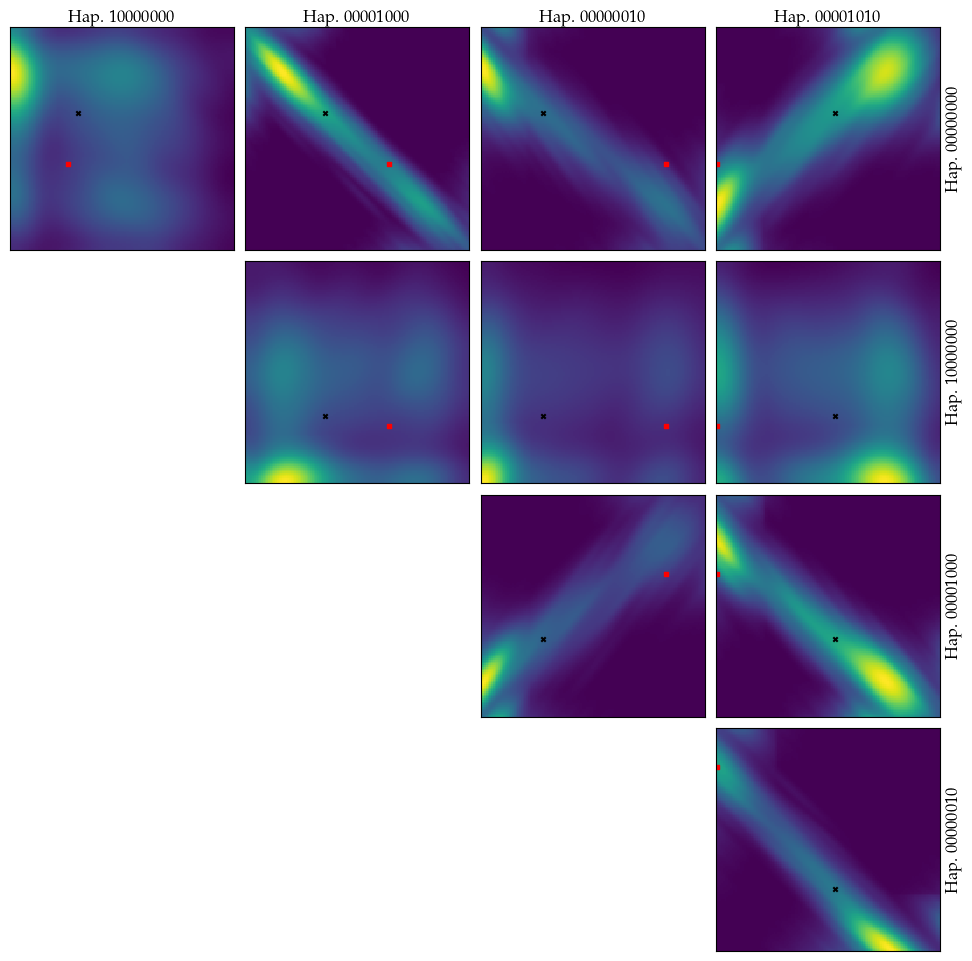

In [139]:
# %%time
gs = 128
H = len(hstrs)
fig, axes = plt.subplots(nrows=H-1, ncols=H-1, figsize=(12, 12))
for i in range(H-1):
    for j in range(H-1):
        if j < i:
            fig.delaxes(axes[i,j])
            continue
        h1, h2 = idxs[i], idxs[1+j]
        ax = axes[i,j]
        # az.plot_kde(postp[:,h2], postp[:,h1], contour=False, ax=ax);
        
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(postp[:,h2], postp[:,h1], (gs, gs))
        xd, yd = (xmax-xmin)/(gs-1), (ymax-ymin)/(gs-1)
        x_x, y_y = np.mgrid[xmin:xmax+xd/2:xd, ymin:ymax+yd/2:yd]
        # x_x = np.r_[ [-10*xd*np.ones(gs+1)], np.c_[ x_x, x_x[:,0] ]]
        # y_y = np.c_[ -10*yd*np.ones(gs+1), np.r_[ [y_y[0]], y_y ] ]
        # grid = np.c_[ np.zeros(gs+1), np.r_[ [np.zeros(gs)], grid ] ]
        ax.pcolormesh(x_x, y_y, grid**0.5);
        
        ax.scatter(ptrue.get(hstrs[1+j], 0),
                   ptrue.get(hstrs[i], 0),
                   color='r', edgecolor='r', marker='s', s=10);
        # print(ptrue.get(hstrs[1+j], 0),
        #            ptrue.get(hstrs[i], 0))
        ax.scatter(pmean[hstrs[1+j]],
                   pmean[hstrs[i]],
                   color='k', marker='x', s=10);
        # ax.set_xlim((0,0.5))
        # ax.set_ylim((0,0.5))
        # ax.set_xticks([0,0.5])
        # ax.set_yticks([0,0.5])
        ax.set_xticks([])
        ax.set_yticks([])
        if j == H-2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Hap. {hstrs[i]}', fontsize=12)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Hap. {hstrs[1+j]}', fontsize=12)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

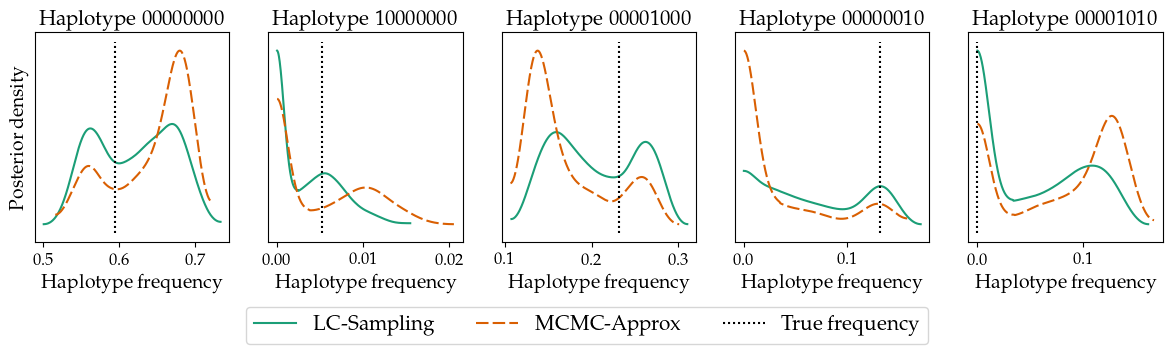

In [17]:
i = 2
psize = 50
hstrs = ['00000000', '10000000', '00001000', '00000010', '00001010']
idata_cgibbs = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_cgibbs.netcdf')
postp_cgibbs = np.vstack(idata_cgibbs.posterior.p)

idata_mn = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_mn_approx.netcdf')
postp_mn = np.vstack(idata_mn.posterior.p)

ptrue = ptrue_list[i]
idxs = []
for idx, hnum in enumerate(haps_list[i]):
    hstr = num_to_str(hnum, 8)
    if hstr in hstrs:
        idxs.append(idx)

nrow = (len(pmean) - 1) // 6 + 1
fig, axes = plt.subplots(ncols=len(hstrs), figsize=(12, 3.5))
for j in range(len(hstrs)):
    ax = axes[j]
    # az.plot_kde(pred_samples_t10[:,j], ax=ax)
    grid, dens = az.stats.density_utils.kde(postp_cgibbs[:,idxs[j]], bw='scott')
    ax.plot(grid, dens, color=colors[0], label='LC-Sampling');

    grid, dens = az.stats.density_utils.kde(postp_mn[:,idxs[j]], bw='scott')
    ax.plot(grid, dens, '--', color=colors[1], label='MCMC-Approx', dashes=(6, 2));   
    
    ax.plot([ptrue.get(hstrs[j], 0)]*2, ax.get_ylim(), color='k', label='True frequency', linestyle=(0, (1, 1.4)))
    # for k in range(1, len(diffs)):
    #     if diffs[k] < 0 and diffs[k-1] > 0:
    #         ax.scatter(grid[k], dens[k], s=10, color='k', alpha=0.5)
    # ax.plot([ptrue.get(hstrs[j], 0)]*2, [0,ax.get_ylim()[1]*0.9], '--', color='k', alpha=0.5)
    ax.set_title(f'Haplotype {hstrs[j]}', fontsize=15)
    ax.set_xlabel('Haplotype frequency', fontsize=14)
    ax.set_yticks([])
    if j == 0:
        ax.set_ylabel('Posterior density', fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0.0), fontsize=15)
plt.subplots_adjust(top=0.92, left=0.04, right=0.98, bottom=0.32);
plt.savefig('kgenomes_multimodal.png', dpi=200, facecolor='white');

In [18]:
print(stats[2]['cgibbs']['pess'][idxs]) # 461-1870
print(stats[2]['mn_approx']['pess'][idxs]) # 123-187
print(stats[2]['hippo']['pess'][[str_to_num(hstr) for hstr in hstrs]]) # 8-68

[ 521.23358006 1870.07447267  506.3097779   475.78984953  461.49044734]
[124.11820985 186.89355332 123.00485642 146.21772391 131.58633073]
[16.84092651 68.33925872 17.59430939  8.15382667 18.66783225]


In [19]:
idata_hippo = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_hippo.netcdf')

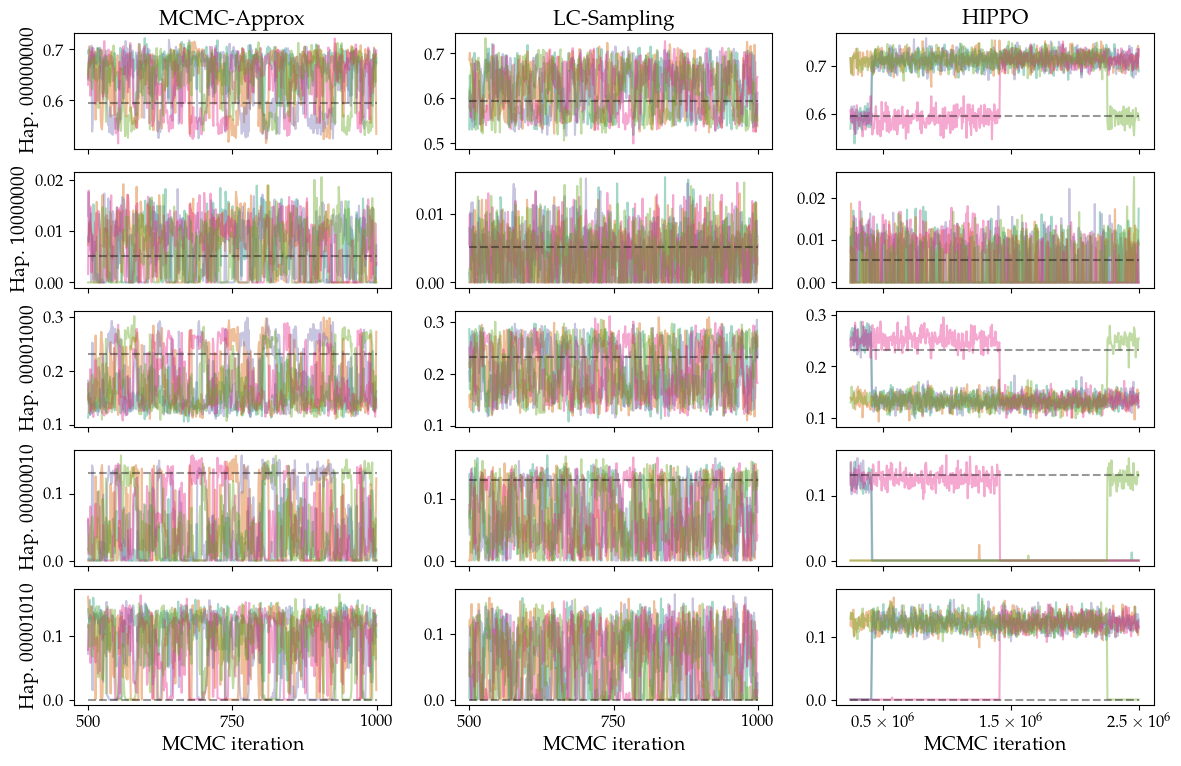

In [25]:
fig, axes = plt.subplots(nrows=len(hstrs), ncols=3, figsize=(12, 8))
for i in range(len(hstrs)):
    for c in range(5):
        axes[i,0].plot(idata_mn.posterior.p[c,:,idxs[i]], color=colors[c], alpha=0.4)
        axes[i,1].plot(idata_cgibbs.posterior.p[c,:,idxs[i]], color=colors[c], alpha=0.4)
        axes[i,2].plot(idata_hippo.posterior.p[c,:,str_to_num(hstrs[i])], color=colors[c], alpha=0.4)
    for j in range(3):
        axes[i,j].plot([0,500], [ptrue.get(hstrs[i], 0)]*2, '--', color='k', alpha=0.4)
        axes[i,j].tick_params(axis='both', which='both', labelsize=12)
        if i == 4:            
            axes[i,j].set_xlabel('MCMC iteration', fontsize=14)
        if j == 2:
            tlocs = (np.array([0.5,1.5,2.5])-0.25)*10**6/4500
            tlabs = [r'$0.5\times 10^6$', r'$1.5\times 10^6$', r'$2.5\times 10^6$'] if i == 4 else ['']*3
        else:
            tlocs = [0,250,500]
            tlabs = [500,750,1000] if i == 4 else ['']*3
        axes[i,j].set_xticks(tlocs, tlabs)
    axes[i,0].set_ylabel(f'Hap. {hstrs[i]}', fontsize=14)

axes[0,0].set_title('MCMC-Approx', fontsize=15);
axes[0,1].set_title('LC-Sampling', fontsize=15);
axes[0,2].set_title('HIPPO', fontsize=15);
    
plt.subplots_adjust(top=0.94, left=0.07, right=0.97, bottom=0.1);
plt.savefig('kgenomes_traces.png', dpi=200, facecolor='white');

## Joint posteriors for multimodality example

In [188]:
# example: cgibbs
i = 2
psize = 50
idata = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_cgibbs.netcdf')
postp = np.vstack(idata.posterior.p)
pmean = make_series(get_pmean(idata), haps_list[i], n_markers)
ptrue = ptrue_list[i]
idxs = []
for idx, hnum in enumerate(haps_list[i]):
    hstr = num_to_str(hnum, 8)
    if hstr in hstrs:
        idxs.append(idx)

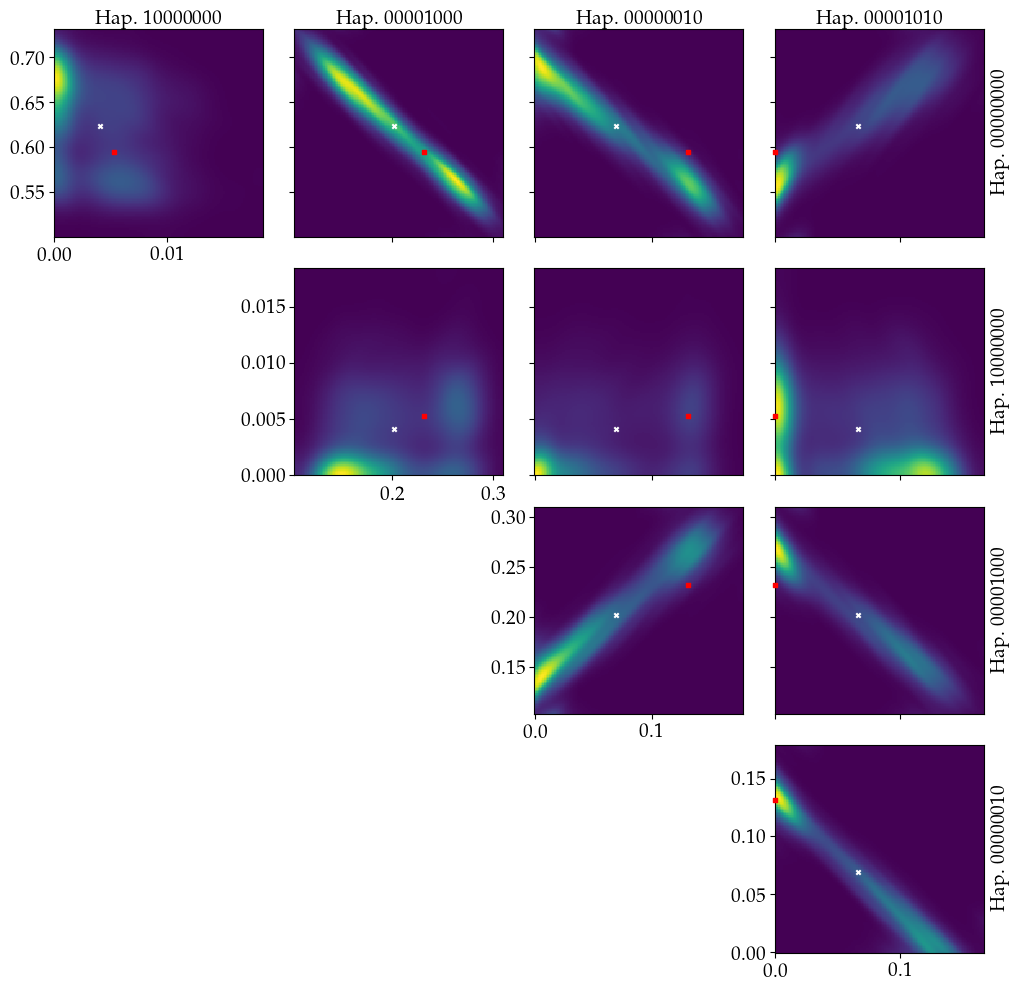

In [189]:
# example: cgibbs
gs = 128
H = len(hstrs)
maxs = np.ones(50)

fig, axes = plt.subplots(nrows=H-1, ncols=H-1, figsize=(12, 12))
for i in range(H-1):
    for j in range(H-1):
        if j < i:
            fig.delaxes(axes[i,j])
            continue
        h1, h2 = idxs[i], idxs[1+j]
        ax = axes[i,j]
        # az.plot_kde(postp[:,h2], postp[:,h1], contour=False, ax=ax);
        
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(postp[:,h2], postp[:,h1], (gs, gs))
        # print(h2, xmax, h1, ymax)
        xd, yd = (xmax-xmin)/(gs-1), (ymax-ymin)/(gs-1)
        x_x, y_y = np.mgrid[xmin:xmax+xd/2:xd, ymin:ymax+yd/2:yd]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(ptrue.get(hstrs[1+j], 0),
                   ptrue.get(hstrs[i], 0),
                   color='r', marker='s', edgecolor='r', s=10,
                   clip_on=False,
                   zorder=100)
        
        ax.scatter(pmean[hstrs[1+j]],
                   pmean[hstrs[i]],
                   color='w', marker='x', s=10)
        # ax.set_xlim((0,maxs[h2]))
        # ax.set_ylim((0,maxs[h1]))
        if i != j:
            xts = [v for v in ax.get_xticks() if ax.get_xlim()[0] < v < ax.get_xlim()[1]]
            ax.set_xticks(xts, ['']*len(xts))
            yts = [v for v in ax.get_yticks() if ax.get_ylim()[0] < v < ax.get_ylim()[1]]
            ax.set_yticks(yts, ['']*len(yts))
        if j == H-2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Hap. {hstrs[i]}', fontsize=14)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Hap. {hstrs[1+j]}', fontsize=14)
plt.subplots_adjust(wspace=0.15, hspace=0.15);

In [190]:
# example: mn_approx
i = 2
psize = 50
idata = az.from_netcdf(f'../../data/encode/psize{psize}_m8_id{i+1}_mn_approx.netcdf')
postp = np.vstack(idata.posterior.p)
pmean = make_series(get_pmean(idata), haps_list[i], n_markers)
ptrue = ptrue_list[i]
idxs = []
for idx, hnum in enumerate(haps_list[i]):
    hstr = num_to_str(hnum, 8)
    if hstr in hstrs:
        idxs.append(idx)

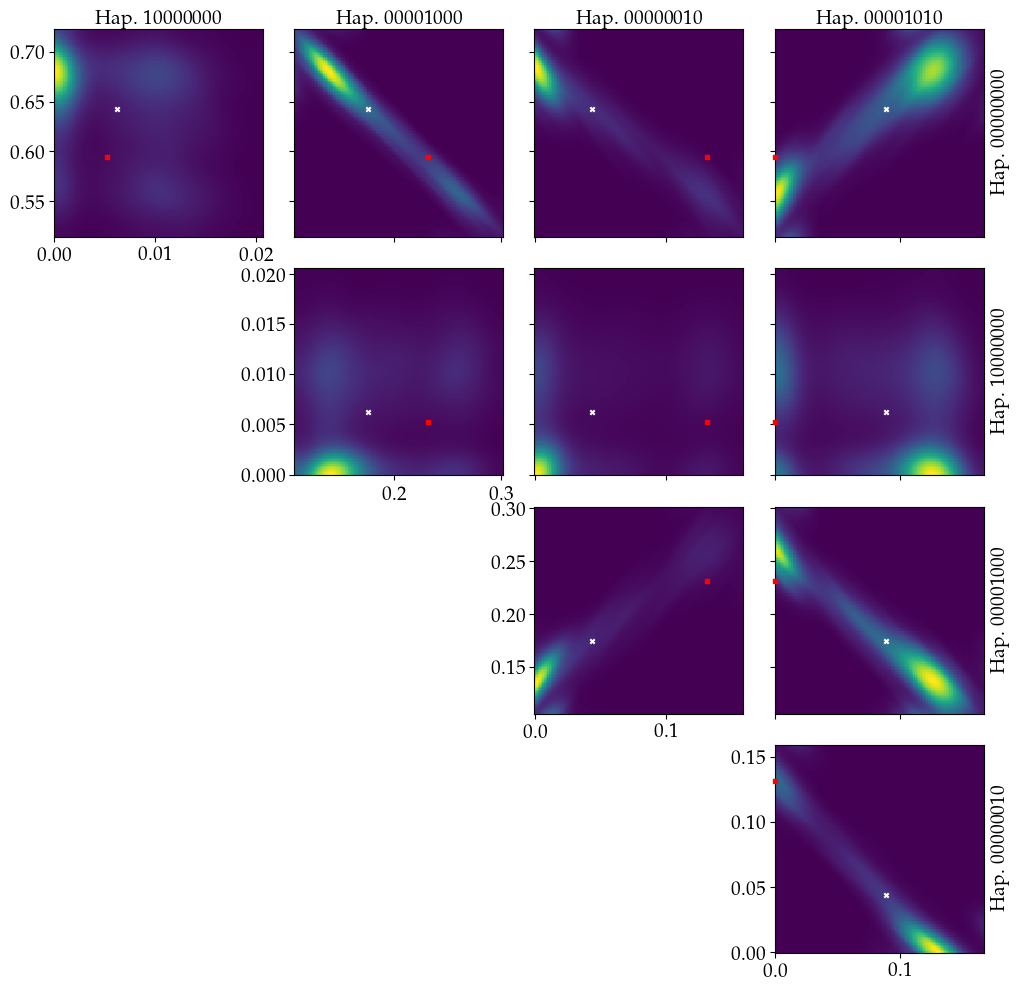

In [191]:
# example: mn_approx
gs = 128
H = len(hstrs)
maxs = np.ones(50)

fig, axes = plt.subplots(nrows=H-1, ncols=H-1, figsize=(12, 12))
for i in range(H-1):
    for j in range(H-1):
        if j < i:
            fig.delaxes(axes[i,j])
            continue
        h1, h2 = idxs[i], idxs[1+j]
        ax = axes[i,j]
        # az.plot_kde(postp[:,h2], postp[:,h1], contour=False, ax=ax);
        
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(postp[:,h2], postp[:,h1], (gs, gs))
        # print(h2, xmax, h1, ymax)
        xd, yd = (xmax-xmin)/(gs-1), (ymax-ymin)/(gs-1)
        x_x, y_y = np.mgrid[xmin:xmax+xd/2:xd, ymin:ymax+yd/2:yd]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(ptrue.get(hstrs[1+j], 0),
                   ptrue.get(hstrs[i], 0),
                   color='r', marker='s', edgecolor='r', s=10, 
                   clip_on=False, zorder=100)
        
        ax.scatter(pmean[hstrs[1+j]],
                   pmean[hstrs[i]],
                   color='w', marker='x', s=10);
        # ax.set_xlim((0,maxs[h2]))
        # ax.set_ylim((0,maxs[h1]))
        if i != j:
            xts = [v for v in ax.get_xticks() if ax.get_xlim()[0] < v < ax.get_xlim()[1]]
            ax.set_xticks(xts, ['']*len(xts))
            yts = [v for v in ax.get_yticks() if ax.get_ylim()[0] < v < ax.get_ylim()[1]]
            ax.set_yticks(yts, ['']*len(yts))
        if j == H-2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Hap. {hstrs[i]}', fontsize=14)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Hap. {hstrs[1+j]}', fontsize=14)
plt.subplots_adjust(wspace=0.15, hspace=0.15);